In [1]:
%cd /scratch_net/biwidl214/ecetin_scratch/GSCodec/

/scratch_net/biwidl214/ecetin_scratch/GSCodec


/scratch_net/biwidl214/ecetin/conda_envs/gscodec/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os
import numpy as np
import torch
import torch.quantization as quantization
from models.compression.entropy_bottleneck import EntropyBottleneckCompressor
from models.splatting.base_model import GaussianParams
from models.splatting.radsplat_gaussian_model import RadSplatGaussianModel
from config.build_config_spaces import ConfigReader
from scene import Scene
from gaussian_renderer import render
import matplotlib.pyplot as plt


Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/pointops/build.ninja...
Building extension module pointops...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module pointops...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/octree_generation/build.ninja...
Building extension module octree_generation...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module octree_generation...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/gaussian_aggregation/build.ninja...
Building extension module gaussian_aggregation...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gaussian_aggregation...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/ecetin/.cache/torch_extensions/py310_cu118/diff_gaussian_rasterization/build.ninja...
Building extension module diff_gaussian_rasterization...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module diff_gaussian_rasterization...
Using /home/ecetin/.cache/torch_extensions/py310_cu118 as PyTorch extensions root...
No modifications detected for re-loaded extension module diff_gaussian_rasterization, skipping build step...
Loading extension module diff_gaussian_rasterization...


In [3]:
reader = ConfigReader("./config/preset_configs/compress_gaussian.yaml")

model_path = './output/radsplat_complete/compressed/entropybottleneck/train/lmbda_5e-04'
checkpoint = os.path.join(model_path, 'checkpoints/ckpt_50000.pth')

optimization = reader.optimization_config
pipeline = reader.pipeline_config
dataset = reader.dataset_config
dataset.data_path = os.path.join(dataset.data_path, "tandt/train")
dataset.model_path = model_path

In [4]:
compressor = EntropyBottleneckCompressor(M=(3 * ((3 + 1) ** 2)) + 3 + 4 + 1, N=32).cuda()
gaussian = RadSplatGaussianModel(dataset)

model_params, entropy_params, _ = torch.load(checkpoint)
gaussian.restore_model(model_params[:-1])
out = compressor.restore_model(entropy_params[0])
compressor.mean_vals = entropy_params[1].cuda()
compressor.std_vals = entropy_params[2].cuda()
print(out)

<All keys matched successfully>


In [5]:
from models.compression.geometry_compression import (
    save_xyz_as_ply, load_xyz_from_ply, gpcc_encode, gpcc_decode, 
    encode_compressed_gaussian_and_compressor, decode_compressed_gaussian_and_compressor,
    sort_parameters, sort_xyz
)

gaussian_params = GaussianParams(
    get_xyz=gaussian.get_xyz,
    get_features=gaussian.get_features,
    get_scaling=gaussian._scaling,
    get_rotation=gaussian._rotation,
    get_opacity=gaussian._opacity,
    active_sh_degree=gaussian.active_sh_degree,
)

# sorted_gaussian_params, sorted_indices = sort_parameters(gaussian_params)
sorted_gaussian_params = gaussian_params
# _, sorted_indices = sort_parameters(gaussian_params)

In [6]:
compressed_result = compressor.compress(sorted_gaussian_params)

In [7]:
# xyz = sorted_gaussian_params.get_xyz

# xyz_plyfilename = "points.ply"
# xyz_binfilename = "points.bin"

# save_xyz_as_ply(xyz, xyz_plyfilename)
# gpcc_encode(xyz_plyfilename, xyz_binfilename)

gaussian_model_and_codec_filename = 'gaussian_model'

bitstring = compressed_result['bitstrings'][0]
model_params = compressor.capture_compressor_params(
    compressed_result["shapes"][0], 
    gaussian.active_sh_degree
)

encode_compressed_gaussian_and_compressor(
    bitstring, model_params, gaussian_model_and_codec_filename
)

In [8]:
from models.compression.compression_utils import get_size_in_MB, calculate_psnr

# # Get the size of the file
# gaussian_xyz_size = os.path.getsize(xyz_binfilename) / (2**20)
# # print(f"The size of the xyz '{xyz_binfilename}' is: {gaussian_xyz_size} MBytes")
# print(f"The size of the xyz is: {get_size_in_MB(gaussian.get_xyz.type(torch.float16))} MBytes")

# Get the size of the file
print(f"The size of the location is: {get_size_in_MB(gaussian_params.get_xyz.type(torch.float16))} MBytes")

gaussian_params_size = os.path.getsize(gaussian_model_and_codec_filename + '.bin') / (2**20)
print(f"The size of the gaussian params '{gaussian_model_and_codec_filename}' is: {gaussian_params_size} MBytes")

model_size = os.path.getsize(gaussian_model_and_codec_filename + '.pth') / (2**20)
print(f"The size of the model params '{gaussian_model_and_codec_filename}' is: {model_size} MBytes")

original_size = (
    get_size_in_MB(gaussian.get_xyz.type(torch.float32))
    + get_size_in_MB(gaussian.get_features.type(torch.float32))
    + get_size_in_MB(gaussian._scaling.type(torch.float32))
    + get_size_in_MB(gaussian._rotation.type(torch.float32))
    + get_size_in_MB(gaussian._opacity.type(torch.float32))
)
print(f"The size of the original model is: {original_size} MBytes")

The size of the location is: 4.495868682861328 MBytes
The size of the gaussian params 'gaussian_model' is: 6.805519104003906 MBytes
The size of the model params 'gaussian_model' is: 0.07075023651123047 MBytes
The size of the original model is: 176.8375015258789 MBytes


In [9]:
loaded_bitstring, loaded_model_params = decode_compressed_gaussian_and_compressor(
    gaussian_model_and_codec_filename
)

# loaded_model_params[0] = state_dict
# loaded_model_params[1] = mean_vals
# loaded_model_params[2] = std_vals
# loaded_model_params[3] = num_gaussians
# loaded_model_params[4] = active_sh_degree
compressor = EntropyBottleneckCompressor(
    M=(3 * ((loaded_model_params[-1] + 1) ** 2)) + 3 + 4 + 1, N=32
).cuda()
compressor.restore_compressor_params(loaded_model_params)
compressor.update()

compressed_attrs = compressor.decompress(
    [loaded_bitstring], [loaded_model_params[3]], loaded_model_params[-1]
)

# gpcc_decode(xyz_binfilename, xyz_plyfilename)
# decoded_xyz = load_xyz_from_ply(xyz_plyfilename)
# sorted_decoded_xyz = sort_xyz(decoded_xyz)

In [11]:
scaling_activation = torch.exp
rotation_activation = torch.nn.functional.normalize
opacity_activation = torch.sigmoid

rec_gaussian_params = GaussianParams(
    get_xyz=gaussian.get_xyz.type(torch.float16).type(torch.float32),
    get_features=compressed_attrs["features"],
    get_scaling=scaling_activation(compressed_attrs["scaling"]),
    get_rotation=rotation_activation(compressed_attrs["rotation"]),
    get_opacity=opacity_activation(compressed_attrs["opacity"]),
    active_sh_degree=loaded_model_params[-1]
)

In [12]:
scene = Scene(dataset, gaussian, load_iteration=None, shuffle=False)
views = scene.getTrainCameras()

Reading camera 301/301


In [13]:
scaling_activation = torch.exp
rotation_activation = torch.nn.functional.normalize
opacity_activation = torch.sigmoid

plotting_gaussian_params = GaussianParams(
    get_xyz=gaussian_params.get_xyz,
    get_features=gaussian_params.get_features,
    get_scaling=scaling_activation(gaussian_params.get_scaling),
    get_rotation=rotation_activation(gaussian_params.get_rotation),
    get_opacity=opacity_activation(gaussian_params.get_opacity),
    active_sh_degree=3
)

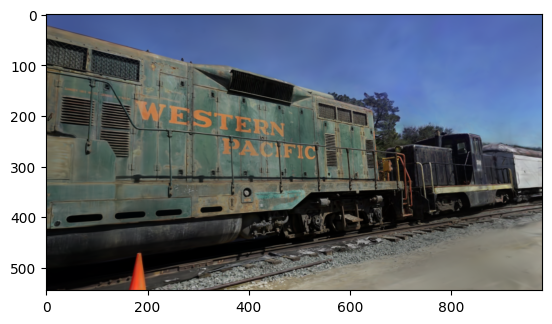

In [20]:
view = views[20]
bg_color = [1, 1, 1] if dataset.white_background else [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

render_pkg = render(
    view, rec_gaussian_params, pipeline, background, testing=True
)
rendering = torch.clamp(render_pkg["render"], 0, 1)

plt.imshow((rendering * 255).permute(1, 2, 0).cpu().detach().numpy().astype(np.uint8))

In [21]:
print(f"PSNR: {calculate_psnr(255 * view.original_image.detach().cpu().numpy(), (rendering * 255).detach().cpu().numpy()):.5f}")

# print(f"Point cloud size is: {get_size_in_MB(gaussian.get_xyz):.5f} MB")
# print(f"Point cloud size is: {get_size_in_MB(gaussian.get_xyz.type(torch.float16)):.5f} MB")

PSNR: 23.21519


In [5]:
compressor.qconfig = torch.quantization.default_dynamic_qconfig
model_prepared = torch.quantization.prepare(compressor, inplace=True)
model_quantized = quantization.convert(model_prepared, inplace=False)


In [9]:
compressor.entropy_bottleneck._matrix0

Parameter containing:
tensor([[[-3.5806],
         [-2.7074],
         [-0.3674]],

        [[-3.6987],
         [-1.7892],
         [-1.7614]],

        [[-2.6951],
         [ 0.5154],
         [-2.6951]],

        [[ 2.0590],
         [ 1.3287],
         [ 1.5082]],

        [[ 1.6293],
         [ 1.8143],
         [ 1.8569]],

        [[ 1.6176],
         [ 1.8753],
         [ 1.9414]],

        [[ 2.5252],
         [ 2.5247],
         [ 2.5113]],

        [[ 1.4772],
         [ 1.5011],
         [ 1.4760]],

        [[ 2.7455],
         [ 2.7530],
         [ 2.7337]],

        [[ 1.8627],
         [ 1.8627],
         [ 1.8681]],

        [[ 2.3922],
         [-1.6333],
         [ 2.4108]],

        [[ 2.1811],
         [ 2.1777],
         [ 2.1680]],

        [[ 2.4249],
         [ 2.1422],
         [ 2.3128]],

        [[ 2.5093],
         [ 2.3025],
         [ 1.8209]],

        [[ 2.5661],
         [ 2.6116],
         [ 2.6128]],

        [[ 2.3785],
         [ 2.2376],
        

In [8]:
model_quantized.entropy_bottleneck._matrix0

Parameter containing:
tensor([[[-3.5806],
         [-2.7074],
         [-0.3674]],

        [[-3.6987],
         [-1.7892],
         [-1.7614]],

        [[-2.6951],
         [ 0.5154],
         [-2.6951]],

        [[ 2.0590],
         [ 1.3287],
         [ 1.5082]],

        [[ 1.6293],
         [ 1.8143],
         [ 1.8569]],

        [[ 1.6176],
         [ 1.8753],
         [ 1.9414]],

        [[ 2.5252],
         [ 2.5247],
         [ 2.5113]],

        [[ 1.4772],
         [ 1.5011],
         [ 1.4760]],

        [[ 2.7455],
         [ 2.7530],
         [ 2.7337]],

        [[ 1.8627],
         [ 1.8627],
         [ 1.8681]],

        [[ 2.3922],
         [-1.6333],
         [ 2.4108]],

        [[ 2.1811],
         [ 2.1777],
         [ 2.1680]],

        [[ 2.4249],
         [ 2.1422],
         [ 2.3128]],

        [[ 2.5093],
         [ 2.3025],
         [ 1.8209]],

        [[ 2.5661],
         [ 2.6116],
         [ 2.6128]],

        [[ 2.3785],
         [ 2.2376],
        

In [14]:
def sort_parameters(gaussian_params: GaussianParams):
    # Convert the tensor to a numpy array for sorting
    xyz = gaussian_params.get_xyz.detach().cpu().numpy()

    # Sort by the third column, then by the second column, then by the first column
    sorted_indices = np.lexsort((xyz[:, 2], xyz[:, 1], xyz[:, 0]))

    # Apply the sorted indices to reorder the array
    sorted_array = xyz[sorted_indices]

    # Convert the sorted array back to a tensor
    sorted_tensor = torch.from_numpy(sorted_array)

tensor([[0., 1., 2.],
        [1., 0., 3.],
        [4., 2., 2.]])

In [16]:
a = torch.Tensor([[0, 1, 2], [1, 0, 3], [4, 2, 2]])
a[a[:, 0].sort()[1]]

tensor([[1., 0., 3.],
        [0., 1., 2.],
        [4., 2., 2.]])